In [1]:
import time
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

from tools import *

In [2]:
robot = load_robot(urdf = "solo_leg/solo12.urdf")

In [3]:
viz = create_visualizer(robot)
viz.viewer.jupyter_cell()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [4]:
JOINT_LIST = ["HFE", "KFE"]
q = np.zeros((robot.nq, 1))

def set_joint(joint, angle):
    q[JOINT_LIST.index(joint)] = angle
    robot.display(q)
    
interact(
    lambda q0, q1: (set_joint("HFE", q0), set_joint("KFE", q1)),
    q0 = FloatSlider(min=-4.2, max=1.57, step=0.01, value=0),
    q1 = FloatSlider(min=-6.28, max=6.28, step=0.01, value=0)
)

interactive(children=(FloatSlider(value=0.0, description='q0', max=1.57, min=-4.2, step=0.01), FloatSlider(val…

<function __main__.<lambda>(q0, q1)>

In [5]:
# Forward kinematics (1x3):
fk_3d = symbolic_fk(robot, ["FOOT"])

# Keep only X and Z components (1x2):
q_sym = ca.SX.sym("q", robot.nq, 1)
fk_planar = ca.Function("fk_planar", [q_sym], [ca.horzcat(fk_3d(q_sym)[0, 0], fk_3d(q_sym)[0, 2])])

In [6]:
J = ca.Function("J", [q_sym], [ca.jacobian(fk_planar(q_sym), q_sym)])

In [7]:
### Inverse Kinematics (for testing) ###
def ik_newton(p_desired, q0 = None):
    """
    p_desired: End effector position to find joint angles for
    q0:        Starting joint angles for iterative optimization
               (random in [-2π, 2π] if None)
    """
    q_k = np.copy(q0) if q0 is not None else np.random.uniform(-2 * np.pi, 2 * np.pi, (robot.nq, 1))
    err = lambda q: (fk_planar(q) - p_desired).T
    m = lambda q: 0.5 * (e := err(q)).T @ e     # 1/2 norm(e(q))^2 merit

    iterations = 0

    while np.max(np.abs(p_desired - fk_planar(q_k))) > 1e-4:
        e_k, m_k, J_k = err(q_k), m(q_k), J(q_k)
        
        # Zero out linearization:
        Δq = -ca.pinv(J_k) @ e_k       

        # Line search using Armijo rule:
        α = 1.
        
        while m(q_k + α * Δq) > m_k + 1e-4 * (e_k.T @ J_k) @ (α * Δq):
            α *= 0.5
            print(f"Linesearch backtracking (α={α})")

        q_k += α * Δq
        iterations += 1

    print(f"Performed IK using Newton in {iterations} iterations.")
    return np.array(q_k)

In [8]:
### Robot dynamics ###
def dynamics(x, τ):
    """ x_dot = f(x, τ) with x = vstack(q, q_dot): 4x1 """
    q, q_dot = x[:2], x[2:]
    return np.vstack([q_dot, pin.aba(robot.model, robot.data, q, q_dot, τ).reshape(-1, 1)])

In [9]:
### Simulation ###
u_hist = []

def integrate_rk4(x, u, h):
    """
    Assume that control input is ZOH for the whole h time period
        TODO: What difference does it make to requery controller?
    """
    
    k1 = dynamics(x, u)             # x_next = x + h * k1 is forward Euler
    k2 = dynamics(x + h/2 * k1, u)
    k3 = dynamics(x + h/2 * k2, u)
    k4 = dynamics(x + h   * k3, u)

    return x + h/6 * (k1 + 2*k2 + 2*k3 + k4)

def simulate(
    q0,
    q_dot0,
    controller,
    h = 1e-4,
    ctrl_period = 1e-3,    # 1kHz control by default
    ctrl_eval_delay = 0.,
    t_max = 4,
    integrator = integrate_rk4,
):
    """
    Starting at x = vstack([`q0`, `qdot_0`]), simulate for `t_max` sec by discretising time
    every `h` sec.
    
    The system input, `controller(q, q_dot)`, is computed every `ctrl_period` seconds.
    If `ctrl_eval_delay` > 0, calculation delay is simulated, ie. the controller's output will
    only be applied after `ctrl_eval_delay` / `h` timesteps (and held for a further
    `ctrl_period` / `h` ticks). For the initial `ctrl_eval_delay` seconds, a zero system input
    is applied.
    
    Use `integrator` to find x(t + h) = f(x(t), τ).
    """
    t = 0.
    x_hist = [np.vstack([q0, q_dot0])]
    u, u_state = np.zeros(controller(q0, q_dot0).shape), None
    
    # Ticks to wait until requerying controller:
    N_ctrl_period = int(round(ctrl_period / h))
    
    # Ticks to calculate control input:
    N_ctrl_eval_delay = int(round(ctrl_eval_delay / h))
    
    while t < t_max:
        # Sample and "save" the robot state at the beginning of controller
        # evaluation. This will be used to generate the new control input
        # after N_ctrl_eval_delay ticks:
        u_state = np.copy(x_hist[-1])
        
        # Apply the old control input while the new one is "calculating":
        for _ in range(N_ctrl_eval_delay):
            x_hist.append(integrator(x_hist[-1], u, h))
            t += h
        
        # Calculate new control input using previously sampled state
        # (similar to the controller having queried the robot at the
        #  beginning of its calculations):
        u = np.array(controller(u_state[:2], u_state[2:]))

        # Apply new controller input for a control period:
        for _ in range(N_ctrl_period):
            x_hist.append(integrator(x_hist[-1], u, h))
            t += h
            
    return x_hist

def visualize(x_hist, cmap = "viridis", render = True):
    xs, ys = zip(*[np.array(fk_planar(x[:2]))[0] for x in x_hist])
    c = [idx / len(xs) for idx in range(len(xs))]
    
    plt.scatter(xs, ys, s = 2, c = c, cmap = cmap)

    ax = plt.gca()
    ax.set_xlim([-0.1, 0.1])
    ax.set_ylim([-0.3, 0.05])
    
    cbar = plt.colorbar()
    cbar.ax.set_ylabel("Trajectory Progress", rotation=270, labelpad=20)
    
    if not render:
        i = 0
        
        for x in x_hist:
            i += 1

            if i % 10 == 0:
                robot.display(x[:2])

In [10]:
# Spring dynamics parameters:
q_rest = np.array([[1.0], [-2.3]]) # 2x1
p_rest = fk_planar(q_rest)         # 1x2

Kp = 15.  * np.eye(2)
Kd = 0.3 * np.eye(2)
M  = 0.2 * np.eye(2)

# Rate of change of Jacobian given joint position and velocity:
v_sym = ca.SX.sym("v", robot.nq, 1)
jac_dot = ca.Function("J_dot", [q_sym, v_sym], [ca.jtimes(J(q_sym), q_sym, v_sym)])

def id_spring_controller_symbolic(q, q_dot):
    # Desired EE spring dynamics:
    p_dd_des = ca.inv(M) @ (-Kp @ (fk_planar(q) - p_rest).T - Kd @ (J(q) @ q_dot))

    # Find corresponding joint acceleration at current state:
    jac_dot_times_v = jac_dot(q, q_dot) @ q_dot
    q_dd_des = ca.pinv(J(q)) @ (p_dd_des - jac_dot_times_v)

    # Perform ID to find τ that achieves the desired q_dd:
    cmodel = cpin.Model(robot.model)
    cdata = cmodel.createData()
    return cpin.rnea(cmodel, cdata, q, q_dot, q_dd_des)

"""
def id_spring_controller(q, q_dot):
    jac = J(q)
    
    # Desired EE spring dynamics:
    p_dd_des = np.linalg.inv(M) @ np.array(-Kp @ (fk_planar(q) - p_rest).T - Kd @ (jac @ q_dot))
    
    # Find corresponding joint acceleration at current state:
    jac_dot_times_v = np.array(jac_dot(q, q_dot)) @ q_dot
    q_dd_des = np.linalg.pinv(jac) @ (p_dd_des - jac_dot_times_v)

    # Perform ID to find τ that achieves the desired q_dd:
    return pin.rnea(robot.model, robot.data, q, q_dot, q_dd_des)
"""

id_spring_controller = ca.Function("controller", [q_sym, v_sym], [id_spring_controller_symbolic(q_sym, v_sym)])

In [11]:
viz.viewer.jupyter_cell()

In [11]:
# Test spring controller by simulating with the foot starting higher than its rest position:
q0_off = ik_newton(p_rest + np.array([[0., 0.08]]), q0 = q_rest)
robot.display(q0_off)

# ~500 Hz effective
x_sim_id = simulate(q0_off, np.zeros((2, 1)), id_spring_controller, h = 1e-4, ctrl_period = 1e-3, ctrl_eval_delay = 1e-3)

Performed IK using Newton in 3 iterations.


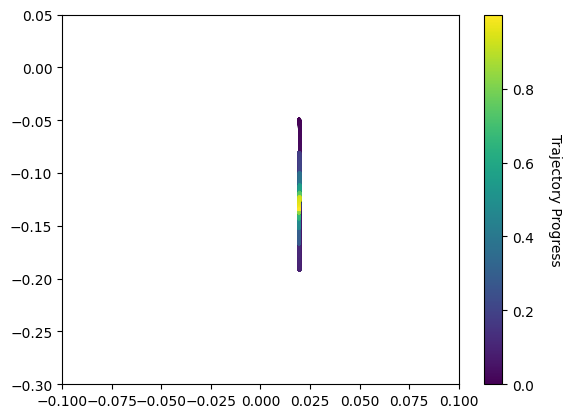

In [12]:
visualize(x_sim_id, render = False)

In [13]:
x_sim_id_low_freq = simulate(q0_off, np.zeros((2, 1)), id_spring_controller, h = 1e-4, ctrl_period = 5e-2, ctrl_eval_delay = 5e-3)

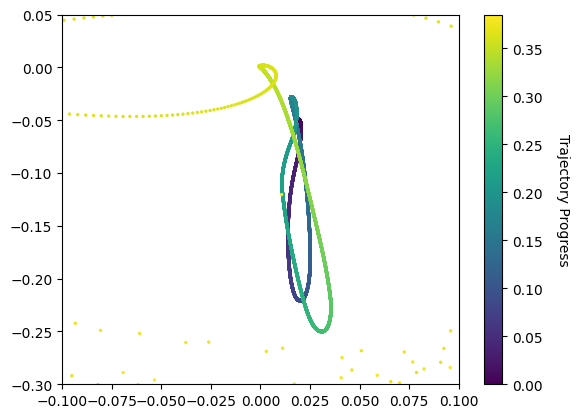

In [14]:
visualize(x_sim_id_low_freq, render = False)

In [17]:
# The task becomes unsolvable because we hit a singularity so the torques are NaN after some point:
x_sim_id_low_freq[-1]

array([[nan],
       [nan],
       [nan],
       [nan]])

In [18]:
def simulate_with_linearization(
    q0, q_dot0, controller, h = 1e-4, t_max = 4,
    integrator = integrate_rk4, recalc_every = 0.05
):
    """
    Similar to `simulate()` above, but instead of ZOH a controller command
    for a `ctrl_period`, calculates an approximate command by querying a controller
    linearization every timestep. Recalculates the linearization every `recalc_every`
    seconds.
    """
    x_sym = ca.SX.sym("x", 4, 1)
    τ = ca.Function("tau", [x_sym], [controller(x_sym[:2], x_sym[2:])])
    δτδx = ca.Function("del_tau_del_x", [x_sym], [ca.jacobian(τ(x_sym), x_sym)])
    
    t_now, t_lin, x_lin = 0.0, None, None
    x_hist = [np.vstack([q0, q_dot0])]
   
    while t_now < t_max:
        x = x_hist[-1]
        
        # If we last linearized more than `recalc_every` seconds,
        # recalculate the A and b matrices around the current state:
        if t_lin is None or t_now - t_lin >= recalc_every:
            A = δτδx(x)
            b = τ(x)
            x_lin = np.copy(x)
            t_lin = t_now
            
        # Simulate using the linearized controller:
        τ_approx = np.array(A @ (x - x_lin) + b)
        x_hist.append(integrator(x, τ_approx, h))
        t_now += h
        
    return x_hist

In [19]:
x_sim_with_lin = simulate_with_linearization(q0_off, np.zeros((2, 1)), id_spring_controller, recalc_every = 5e-2)

In [20]:
viz.viewer.jupyter_cell()

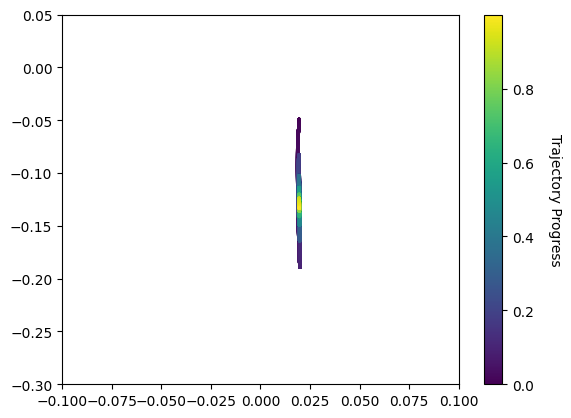

In [21]:
visualize(x_sim_with_lin, render = False)

In [22]:
# Generate controller evaluation and linearization code:
codegen = ca.CodeGenerator("id_spring.c", {"with_header": True})

x_sym = ca.SX.sym("x", 4, 1)
τ = ca.Function("id_spring_controller",        [x_sym], [id_spring_controller(x_sym[:2], x_sym[2:])])
δτδx = ca.Function("delta_controller_delta_x", [x_sym], [ca.jacobian(τ(x_sym), x_sym)])
    
codegen.add(τ) # To evaluate full controller and generate `b` vector when linearizing
codegen.add(δτδx)

codegen.generate("codegen/")

'codegen/id_spring.c'